# sGDML PES Application
- http://docs.sgdml.org/applications.html#md-simulations

In [34]:
from sgdml.intf.ase_calc import SGDMLCalculator
from ase.io import read, write
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.io.trajectory import Trajectory
from ase.md.verlet import VelocityVerlet
from ase.vibrations import Vibrations
from ase import units

In [31]:
#model_path = 'ethanol.npz'
model_path = 'CH2OO-QChem-train1000-sym1.npz'
calc = SGDMLCalculator(model_path)

mol = read('CH2OO_TS.xyz')
mol.set_calculator(calc)

[WARN] Please remember to specify the proper conversion factors, if your model does not use
       'kcal/mol' and 'Ang' as units.


In [32]:
# do a quick geometry relaxation
qn = QuasiNewton(mol)
qn.run(1e-4, 100)

# run the vibration calculations
vib = Vibrations(mol)
vib.run()

vib.summary() # print a summary of the vibrational frequencies
vib.write_jmol() # write file for viewing of the modes with jmol

vib.clean() # remove pickle-files
write('CH2OO_opt.xyz', mol)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 16:40:38    -3127.101943        4.1539
BFGSLineSearch:    1[  1] 16:40:38    -3128.648894        3.8858
BFGSLineSearch:    2[  3] 16:40:38    -3129.120964        3.2383
BFGSLineSearch:    3[  5] 16:40:38    -3129.241653        2.1169
BFGSLineSearch:    4[  7] 16:40:38    -3129.293163        2.4079
BFGSLineSearch:    5[  9] 16:40:39    -3129.364893        3.1274
BFGSLineSearch:    6[ 11] 16:40:39    -3129.485649        1.8776
BFGSLineSearch:    7[ 13] 16:40:39    -3129.547719        0.5473
BFGSLineSearch:    8[ 14] 16:40:39    -3129.556954        0.1713
BFGSLineSearch:    9[ 16] 16:40:39    -3129.561933        0.4048
BFGSLineSearch:   10[ 18] 16:40:39    -3129.566942        0.2502
BFGSLineSearch:   11[ 19] 16:40:39    -3129.568290        0.0729
BFGSLineSearch:   12[ 20] 16:40:39    -3129.568355        0.0239
BFGSLineSearch:   13[ 21] 16:40:39    -3129.568374        0.0057
BFGSLineSearch:   14[ 22]

From [sGDML tutorial](http://docs.sgdml.org/applications.html)

![ethanol frequencies](ethanol_freq.png)

## Molecular Dynamics

In [41]:
#model_path = 'ethanol.npz'
model_path = 'CH2OO-QChem-train1000-sym1.npz'
calc = SGDMLCalculator(model_path)

mol = read('CH2OO_TS.xyz')
mol.set_calculator(calc)

[WARN] Please remember to specify the proper conversion factors, if your model does not use
       'kcal/mol' and 'Ang' as units.


### Can optimize the geometry before optionally

In [42]:
qn = QuasiNewton(mol)
qn.run(1e-4, 100)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 13:18:55    -3127.101943        4.1539
BFGSLineSearch:    1[  1] 13:18:55    -3128.648894        3.8858
BFGSLineSearch:    2[  3] 13:18:55    -3129.120964        3.2383
BFGSLineSearch:    3[  5] 13:18:55    -3129.241653        2.1169
BFGSLineSearch:    4[  7] 13:18:55    -3129.293163        2.4079
BFGSLineSearch:    5[  9] 13:18:55    -3129.364893        3.1274
BFGSLineSearch:    6[ 11] 13:18:55    -3129.485649        1.8776
BFGSLineSearch:    7[ 13] 13:18:55    -3129.547719        0.5473
BFGSLineSearch:    8[ 14] 13:18:55    -3129.556954        0.1713
BFGSLineSearch:    9[ 16] 13:18:55    -3129.561933        0.4048
BFGSLineSearch:   10[ 18] 13:18:55    -3129.566942        0.2502
BFGSLineSearch:   11[ 19] 13:18:55    -3129.568290        0.0729
BFGSLineSearch:   12[ 20] 13:18:55    -3129.568355        0.0239
BFGSLineSearch:   13[ 21] 13:18:55    -3129.568374        0.0057
BFGSLineSearch:   14[ 22]

True

In [43]:
# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(mol, 300 * units.kB)
Stationary(mol) # zero linear momentum
ZeroRotation(mol) # zero angular momentum

# run MD with constant energy using the velocity verlet algorithm
#dyn = VelocityVerlet(mol, 0.2 * units.fs, trajectory='md.traj')  # 0.2 fs time step.
traj = Trajectory('md3.traj', 'w', mol)
# run MD with constant energy using the VelocityVerlet algorithm
dyn = VelocityVerlet(mol, 0.2 * units.fs)  # 0.2 fs time step.
dyn.attach(traj.write, interval=10)
def printenergy(a=mol):
        # function to print the potential, kinetic and total energy
        epot = a.get_potential_energy() / len(a)
        ekin = a.get_kinetic_energy() / len(a)
        print(' Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
#dyn.attach(printenergy, interval=10)
# now run the dynamics
printenergy(mol)
#dyn.run(1000)
ep = []
ek = []
T = []
def printenergy(a):
        # function to print the potential, kinetic and total energy
        epot = a.get_potential_energy() / len(a)
        ep.append(epot)
        ekin = a.get_kinetic_energy() / len(a)
        ek.append(ekin)
        T.append(ekin / (1.5 * units.kB))
        print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# now run the dynamics
printenergy(mol)
#view(mol)
time = []
for i in range(1000):
        dyn.run(100)
        printenergy(mol)
        time.append(i*0.2 * units.fs)
traj.close()

# Now save to extended xyz file
#write('CH2OO_MD.xyz', read('md3.traj',index=':')) # Need to figure out how to converst md.traj into xyz
plt.scatter(time,T)

/var/folders/v6/f7krrsln60z52gdb1kdx_qtdcsryb3/T/ipykernel_86576/2031447041.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
/var/folders/v6/f7krrsln60z52gdb1kdx_qtdcsryb3/T/ipykernel_86576/2031447041.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '


 Energy per atom: Epot = -625.914eV  Ekin = 0.023eV (T=177K)  Etot = -625.891eV
Energy per atom: Epot = -625.914eV  Ekin = 0.023eV (T=177K)  Etot = -625.891eV
Energy per atom: Epot = -625.905eV  Ekin = 0.014eV (T=110K)  Etot = -625.891eV
Energy per atom: Epot = -625.908eV  Ekin = 0.018eV (T=137K)  Etot = -625.891eV
Energy per atom: Epot = -625.904eV  Ekin = 0.013eV (T=102K)  Etot = -625.891eV
Energy per atom: Epot = -625.905eV  Ekin = 0.015eV (T=113K)  Etot = -625.891eV
Energy per atom: Epot = -625.909eV  Ekin = 0.018eV (T=139K)  Etot = -625.891eV
Energy per atom: Epot = -625.904eV  Ekin = 0.013eV (T=101K)  Etot = -625.891eV
Energy per atom: Epot = -625.910eV  Ekin = 0.019eV (T=145K)  Etot = -625.891eV
Energy per atom: Epot = -625.902eV  Ekin = 0.011eV (T= 83K)  Etot = -625.891eV
Energy per atom: Epot = -625.902eV  Ekin = 0.011eV (T= 88K)  Etot = -625.891eV
Energy per atom: Epot = -625.905eV  Ekin = 0.014eV (T=112K)  Etot = -625.891eV
Energy per atom: Epot = -625.903eV  Ekin = 0.012eV 

NameError: name 'plt' is not defined

### Save trajectory to extended .xyz format

In [37]:
import sys
import os.path
from ase.io.trajectory import Trajectory
from ase.io import write

our_dir = 'outmd'
if os.path.isdir(our_dir):
        sys.exit('Output directory already exists.')
else:
        os.mkdir(our_dir)

traj = Trajectory('md3.traj')
for i,atoms in enumerate(traj):
        atoms.wrap()
        #write(our_dir + '/step'+("{:05d}".format(i))+'.xyz', atoms, append=False)
        write(our_dir + '/MD3.xyz', atoms, append=True)


### Examine velocity autocorrelation

In [6]:
import numpy as np
from scipy.fftpack import fft, fftfreq
from ase.io.trajectory import Trajectory

def pdos(V, dt):
    """
    Calculate the phonon density of states from a trajectory of
    velocities (power spectrum of the velocity auto-correlation
    function).

    Parameters
    ----------
    V : :obj:`numpy.ndarray`
        (dims N x T) velocities of N degrees of freedom for
        trajetory of length T
    dt : float
        time between steps in trajectory (fs)

    Returns
    -------
    freq : :obj:`numpy.ndarray`
        (dims T) Frequencies (cm^-1)
    pdos : :obj:`numpy.ndarray`
        (dims T) Density of states (a.u.)
    """

    n_steps = V.shape[1]

    # mean velocity auto-correlation for all degrees of freedom
    vac2 = [np.correlate(v, v, 'full') for v in V]
    vac2 /= np.linalg.norm(vac2, axis=1)[:, None]
    vac2 = np.mean(vac2, axis=0)

    # power spectrum (phonon density of states)
    pdos = np.abs(fft(vac2))**2
    pdos /= np.linalg.norm(pdos) / 2 # spectrum is symmetric

    freq = fftfreq(2*n_steps-1, dt) * 33356.4095198152 # Frequency in cm^-1

    return freq[:n_steps], pdos[:n_steps]

# load MD trajectory
traj = Trajectory('md.traj')

# read velocities
V = np.array([atoms.get_velocities() for atoms in traj])

# time step that was used for the MD simulation
dt = 0.2

n_steps = V.shape[0]
V = V.reshape(n_steps, -1).T
freq, pdos = pdos(V, dt)

# smoothing of the spectrum
# (removes numerical artifacts due to finite time trunction of the FFT)
from scipy.ndimage import  gaussian_filter1d as gaussian
pdos = gaussian(pdos, sigma=50)

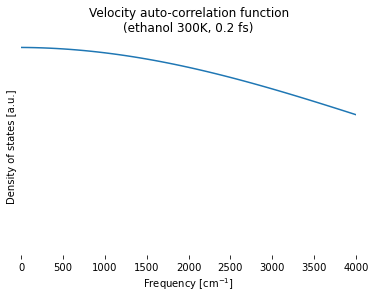

In [7]:
import matplotlib.pyplot as plt

plt.plot(freq, pdos)
plt.yticks([])
plt.xlim(0, 4000)

plt.box(on=None)

plt.xlabel('Frequency [cm$^{-1}$]')
plt.ylabel('Density of states [a.u.]')
plt.title('Velocity auto-correlation function\n(ethanol 300K, 0.2 fs)')
plt.savefig('vaf.png')
plt.show()